In [12]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gamma
from models.networks_2022 import BranchedNetwork
from models.pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
from data.ReconstructionTrainingDataset import CleanSoundsDataset 
from torch.utils.data import DataLoader
from torch.utils.data import Subset

In [44]:
# Which network to test
pnet_name = 'pnet_gammaStripeNoise'
chckpt = 70

In [45]:
engram_dir = '/Users/chingfang/temp_locker/'

In [46]:
# Set up parameters
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
datafile = f'{engram_dir}clean_reconstruction_training_set.hdf5'
PNetClass = PBranchedNetwork_AllSeparateHP
n_timesteps = 5
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']

Device: cpu


In [47]:
# Load network
net = BranchedNetwork()
pnet = PNetClass(net, build_graph=True)
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        string = f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t"
        string += f"fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t"
        string += f"erm: {getattr(pnet,f'erm{pc+1}'):0.3f}"
        print(string)
pnet.load_state_dict(torch.load(
    f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
    map_location='cpu'
    ))
pnet.to(DEVICE)
pnet.build_graph = False
pnet.eval();
print_hps(pnet)

PCoder1 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder2 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder3 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder4 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder5 : ffm: 0.300 	fbm: 0.300 	erm: 0.010


In [48]:
# Set up test dataset
full_dataset = CleanSoundsDataset(datafile)
n_train = int(len(full_dataset)*0.9)
eval_dataset = Subset(full_dataset, np.arange(n_train, len(full_dataset)))
del full_dataset

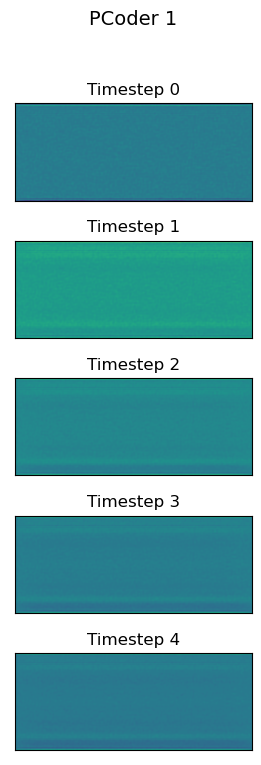

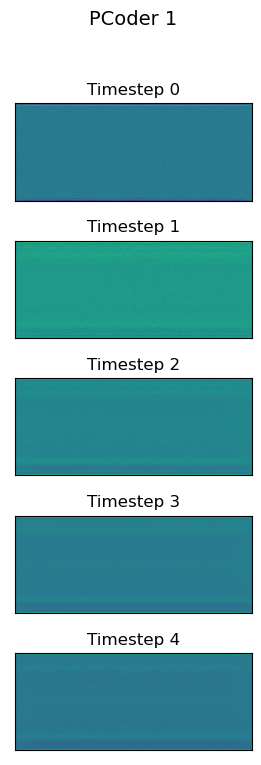

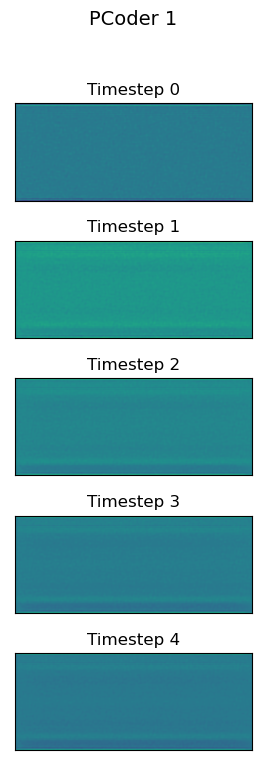

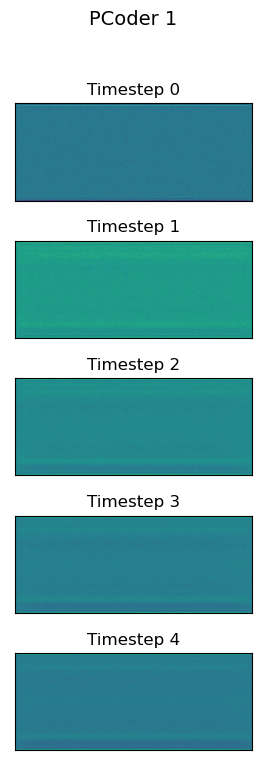

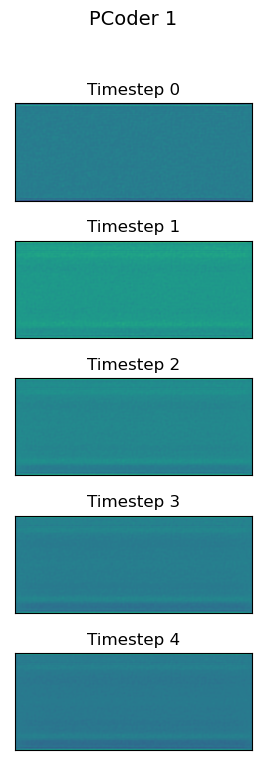

In [49]:
# Plot reconstructions over successive timesteps
for i in range(5):
    pnet.reset()
    fig, axs = plt.subplots(5, 1, figsize = (6, 8))
    with torch.no_grad():
        for j in range(n_timesteps):
            _input = eval_dataset[i][0] if j == 0 else None
            if _input is not None:
                _input = _input.to(DEVICE)
                _input = _input.unsqueeze(0)
                _input = torch.normal(0, 10, size=_input.shape)
                #_input[0,0,80:110,50:150] = 1E-3
                init_img = _input.numpy().copy().squeeze()
                test_shape = _input.shape
            outputs = pnet(_input)
            reconstruction = np.array(pnet.pcoder1.prd[0,0].cpu())
            if j == 0:
                axs[j].imshow(reconstruction)
            else:
                axs[j].imshow(reconstruction) # - init_img)
            axs[j].set_title(f'Timestep {j}')
    for ax in axs:
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle(f'PCoder 1', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'../figures/16b_{pnet_name}_input(i).png', dpi=300)